# Unobserved components model with stochastic volatility - particle filter fit

Hopefully better than MCMC

# 1. Read data

In [1]:
import pandas as pd
from seminartools.data import read_inflation

df = read_inflation()
df

,Country Code,IMF Country Code,Country,yearmonth,inflation
8537,ESP,184,Spain,1970-04-01,0.000000
11635,GTM,258,Guatemala,1970-04-01,0.012577
1231,AUS,193,Australia,1970-04-01,0.011236
7708,DOM,243,Dominican Republic,1970-04-01,-0.001604
21697,NZL,196,New Zealand,1970-04-01,0.015421
...,...,...,...,...,...
16098,KOR,542,"Korea, Rep.",2023-01-01,0.010538
15095,JPN,158,Japan,2023-01-01,0.004500
14347,ITA,136,Italy,2023-01-01,0.003938
21470,NOR,142,Norway,2023-01-01,0.006886


/tmp/ipykernel_4173242/2129217928.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_df["pi"] = (1 + country_df["inflation"]).cumprod()


<Axes: xlabel='yearmonth'>

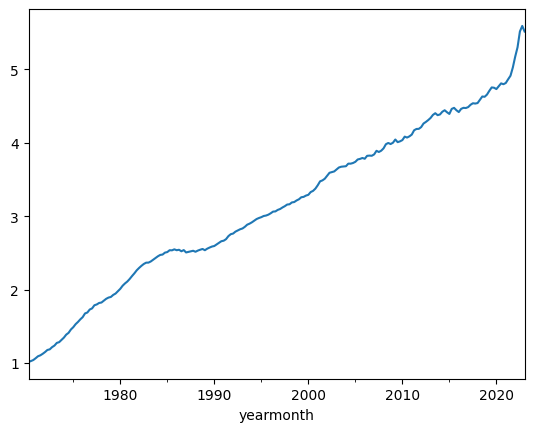

In [2]:
country_df = df[df["Country"] == "Netherlands"]
country_df["pi"] = (1 + country_df["inflation"]).cumprod()
country_df.set_index("yearmonth")["pi"].plot()

In [3]:
len(country_df)

212

# 2. Construct PF

In [ ]:
import numpy as np

class UCSVPF:
    def __init__(
        self,
        num_particles: int,
    ):
        self.num_particles = num_particles

    def fit(self, data: pd.DataFrame):
        particles = np.random.rand(self.num_particles, 4)